## <u>docker commands</u>

docker pull cassandra:latest

docker run --name cassandra-container -p 9042:9042 -d cassandra:latest

docker exec -it cassandra-container cqlsh


In [ ]:
import numpy as np
import pandas as pd
import csv
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement, ConsistencyLevel, BatchType
import os


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## <u>setting up dataframes <u>

In [ ]:
base_path = "data"

artist_df = pd.read_csv(os.path.join(base_path,'spotify_artist_data_2023.csv'))
albums_df = pd.read_csv(os.path.join(base_path,'spotify-albums_data_2023.csv'))
features_df = pd.read_csv(os.path.join(base_path,'spotify_features_data_2023.csv'))
tracks_df = pd.read_csv(os.path.join(base_path,'spotify_tracks_data_2023.csv'))
data_df = pd.read_csv(os.path.join(base_path,'spotify_data_12_20_2023.csv'))

/var/folders/r5/cdmdfg1d7gqdrp5wgjrh815w0000gq/T/ipykernel_93269/4063517290.py:7: DtypeWarning: Columns (25,26,44) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv(os.path.join(base_path,'spotify_data_12_20_2023.csv'))


In [ ]:
##setting up our albums df

drop_columns = ['artist_0', 'artist_1', 'artist_2', 'artist_3', 'artist_4', 'artist_5', 'artist_6', 'artist_7', 'artist_8', 'artist_9', 'artist_10', 'artist_11']

# Fill 'artists' column containing lists of non-null artists
albums_df['artists'] = albums_df.apply(lambda row: [value for key, value in row.items() if key in drop_columns and pd.notna(value)], axis=1)

albums_df = albums_df.drop(drop_columns, axis=1)

# Identify albums with missing values in the specified columns
albums_with_missing_tracks = albums_df[albums_df[albums_df.columns].isna().any(axis=1)]['album_id'].unique()

# Remove entire albums with missing values
albums_df = albums_df[~albums_df['album_id'].isin(albums_with_missing_tracks)]

albums_df = pd.merge(albums_df, tracks_df[['id', 'track_popularity']], left_on='track_id', right_on='id', how='inner')

albums_df = albums_df.drop(['id'], axis=1)

# Convert release_date to datetime
albums_df['release_date'] = pd.to_datetime(albums_df['release_date'], utc=True)

# Create release_year, release_month and release_day columns
albums_df['release_year'] = albums_df['release_date'].dt.year
albums_df['release_month'] = albums_df['release_date'].dt.month
albums_df['release_day'] = albums_df['release_date'].dt.day

# Add tracks features
features_columns = ['danceability', 'loudness', 'energy', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'id']

albums_df = pd.merge(albums_df, features_df[features_columns], left_on='track_id', right_on='id', how='inner')
albums_df = albums_df.drop(['id'], axis=1)

albums_df = pd.merge(albums_df, artist_df[['id', 'artist_genres']], left_on='artist_id', right_on='id', how='left')
albums_df = albums_df.drop(['id'], axis=1)

print(albums_df.shape[1])



27


## <u>code for inserting data into cassandra table </u>

note that when using batch we should make our batch all with the same partition key

below is code to enter the track info csv.  We first create seperate dataframes based on potential values for primary keys and then insert individually
    
We still need to change the code to work for our exact desired tables
    
    

In [ ]:
## connect to cassandra
try:
    cluster = Cluster(['127.0.0.1'])
    session = cluster.connect()
except Exception as e:
    print(e)

In [ ]:
## create keyspace

try:
    session.execute("""
        CREATE KEYSPACE IF NOT EXISTS spotify
        WITH REPLICATION =
        {'class': 'SimpleStrategy', 'replication_factor': 1}
    """)

except Exception as e:
    print(e)


session.set_keyspace('spotify')

In [ ]:
# session.execute("DROP TABLE spotify.track_info_release_year;")

In [ ]:
## create table 1

try:
    session.execute("""
        CREATE TABLE IF NOT EXISTS track_info_release_year (
            track_name TEXT,
            track_id TEXT,
            track_number TEXT,
            duration_ms TEXT,
            album_type TEXT,
            artists TEXT,
            total_tracks TEXT,
            album_name TEXT,
            release_date TEXT,
            label TEXT,
            album_popularity TEXT,
            album_id TEXT,
            artist_id TEXT,
            duration_sec TEXT,
            release_year TEXT,
            track_popularity TEXT,
            release_month TEXT,
            release_day TEXT,
            danceability FLOAT,
            loudness FLOAT,
            energy FLOAT,
            speechiness FLOAT,
            acousticness FLOAT,
            instrumentalness FLOAT,
            liveness FLOAT,
            valence FLOAT,
            tempo FLOAT,
            artist_genres TEXT,
            PRIMARY KEY (release_year, track_id));
    """)
except Exception as e:
    print(e)

In [ ]:
## create table 2

try:
    session.execute("""
        CREATE TABLE IF NOT EXISTS track_info_popularity (
            track_name TEXT,
            track_id TEXT,
            track_number TEXT,
            duration_ms TEXT,
            album_type TEXT,
            artists TEXT,
            total_tracks TEXT,
            album_name TEXT,
            release_date TEXT,
            label TEXT,
            album_popularity TEXT,
            album_id TEXT,
            artist_id TEXT,
            duration_sec TEXT,
            track_popularity TEXT,
            release_year TEXT,
            release_month TEXT,
            release_day TEXT,
            danceability FLOAT,
            loudness FLOAT,
            energy FLOAT,
            speechiness FLOAT,
            acousticness FLOAT,
            instrumentalness FLOAT,
            liveness FLOAT,
            valence FLOAT,
            tempo FLOAT,
            artist_genres TEXT,
            PRIMARY KEY (track_popularity, track_id));
    """)
except Exception as e:
    print(e)

In [ ]:
## reduce csv size

def limit_csv_lines(input_path, output_path, limit):
    with open(input_path, 'r', newline='') as input_file:
        csv_reader = csv.reader(input_file)
        header = next(csv_reader, None)  # Assuming the file has a header

        lines_to_write = []
        for _ in range(limit):
            try:
                row = next(csv_reader)
                lines_to_write.append(row)
            except StopIteration:
                break

    with open(output_path, 'w', newline='') as output_file:
        csv_writer = csv.writer(output_file)
        if header:
            csv_writer.writerow(header)
        csv_writer.writerows(lines_to_write)

In [ ]:
## using batch

def convert_to_types(type_list, string_list):
    converted_tuple = tuple(data_type(value) for data_type, value in zip(type_list, string_list))
    return converted_tuple

# should recieve a df with all records having the same partition key
def df_to_cassandra(df, prepared_query, types, batch_size=20, has_header=True):
    for chunk_start in range(0, len(df), batch_size):
        chunk_end = min(chunk_start + batch_size, len(df))
        chunk = df.iloc[chunk_start:chunk_end]

        batch = BatchStatement(consistency_level=ConsistencyLevel.QUORUM, batch_type=BatchType.UNLOGGED)
        for index, row in chunk.iterrows():
            converted_vals = convert_to_types(types, row.tolist())
            batch.add(prepared_query, converted_vals)
        session.execute(batch)


In [ ]:
#prep datafram

df_sorted_release_year = albums_df.sort_values(by='release_year', ascending=False)
df_sorted_popularity = albums_df.sort_values(by='track_popularity', ascending=False)

print(df_sorted_release_year.shape)

(438014, 28)


In [ ]:
df_sorted_popularity.iloc[0]

track_name                       Cruel Summer
track_id               1BxfuPKGuaTgP7aM0Bbdwr
track_number                                2
duration_ms                            178426
album_type                              album
artists                        [Taylor Swift]
total_tracks                               18
album_name                              Lover
release_date        2019-08-23 00:00:00+00:00
label                            Taylor Swift
album_popularity                           97
album_id               1NAmidJlEaVgA3MpcPFYGq
artist_id              06HL4z0CvFAxyc27GXpf02
duration_sec                          178.426
track_popularity                           99
release_year                             2019
release_month                               8
release_day                                23
danceability                            0.552
loudness                               -5.707
energy                                  0.702
speechiness                       

In [ ]:
#track_name, track_id,track_number ,duration_ms,album_type, artists,total_tracks ,album_name, release_date,label, album_popularity, album_id, artist_id, duration_sec, track_popularity, release_year, release_month, release_day, danceability, loudness, energy, speechiness, acousticness, instrumentalness, liveness, valence       ,tempo,

In [ ]:
# insert release year datafram to casandra table

types = [str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,float,float,float,float,float,float,float,float,float,str]

statement_track_info = '''
INSERT INTO track_info_release_year
(track_name, track_id,track_number ,duration_ms,album_type, artists,total_tracks ,album_name, release_date,label, album_popularity, album_id, artist_id, duration_sec, track_popularity, release_year, release_month, release_day, danceability, loudness, energy, speechiness, acousticness, instrumentalness, liveness, valence,tempo, artist_genres)
 VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?);
'''
prepared_query = session.prepare(statement_track_info)

# for max performance we should split out csv by partition
df_to_cassandra(df_sorted_release_year, prepared_query, types)


In [ ]:
# insert popularity datafram to casandra table
statement_track_info = '''
INSERT INTO track_info_popularity
(track_name,track_id,track_number,duration_ms,album_type,artists,total_tracks,album_name,release_date,label,album_popularity,album_id,artist_id,duration_sec,track_popularity, release_year,release_month,release_day,danceability,loudness,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_genres)
 VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
'''
prepared_query = session.prepare(statement_track_info)

# for max performance we should split out csv by partition
df_to_cassandra(df_sorted_popularity, prepared_query, types)


In [ ]:
## some queries for table partitioned by year

def find_average_of_property_from_year(property, start, end):
    avgs = []
    for year in range(start, end + 1):
        statement = f"SELECT AVG({property}) FROM track_info_release_year WHERE release_year = '{year}';"
        avgs.append(session.execute(statement).one()[0])
    return avgs

def get_all_tracks_in_year(year):
    statement = f"SELECT * FROM track_info_release_year WHERE release_year = '{year}';"
    return session.execute(statement)._current_rows




In [ ]:
## some queries for table partitioned by popularity

def find_average_of_property_with_popularity_range(property, start, end):
    avgs = []
    for popularity in range(start, end + 1):
        statement = f"SELECT AVG({property}) FROM track_info_popularity WHERE track_popularity = '{popularity}';"
        avgs.append(session.execute(statement).one()[0])
    return(avgs)

def get_all_tracks_with_popularity(popularity, column):
    statement = f"SELECT {column} FROM track_info_popularity WHERE track_popularity = '{popularity}';"
    return session.execute(statement)._current_rows


## <u>Executing queries<u>

In [ ]:
statement_count_rows_1 = "SELECT count(*) from track_info_release_year"
print(session.execute(statement_count_rows_1)._current_rows)

statement_count_rows_2 = "SELECT count(*) from track_info_popularity"
print(session.execute(statement_count_rows_2)._current_rows)

[Row(count=438008)]
[Row(count=437989)]


In [ ]:
find_average_of_property_from_year("tempo", 2000,2005)

[115.92269897460938,
 115.78133392333984,
 114.78975677490234,
 116.50296020507812,
 117.40702056884766,
 115.0024642944336]

In [ ]:
find_average_of_property_with_popularity_range("tempo", 90,99)

[102.38300323486328,
 119.17591857910156,
 113.51419830322266,
 138.3979949951172,
 125.17160034179688,
 158.4169921875,
 139.05599975585938,
 96.05699920654297,
 113.94999694824219,
 160.1334991455078]

In [ ]:
get_all_tracks_with_popularity("99", "track_name")
#get_all_tracks_with_popularity("99", "*")

[Row(track_name='All I Want For Christmas Is You'),
 Row(track_name='Cruel Summer')]

In [ ]:
# compare popular tracks to not popular tracks
popular_valence = find_average_of_property_with_popularity_range("valence", 90, 99)
unpopular_valence = find_average_of_property_with_popularity_range("valence", 0, 9)

popular_danceability = find_average_of_property_with_popularity_range("danceability", 90, 99)
unpopular_danceability = find_average_of_property_with_popularity_range("danceability", 0, 9)

popular_energy = find_average_of_property_with_popularity_range("energy", 90, 99)
unpopular_energy = find_average_of_property_with_popularity_range("energy", 0, 9)

popular_liveness = find_average_of_property_with_popularity_range("liveness", 90, 99)
unpopular_liveness = find_average_of_property_with_popularity_range("liveness", 0, 9)

In [ ]:
def print_popular_vs_unpopular(l1,l2):
    assert len(l1) == len(l2)
    s = "popular    VS    unpopular \n"
    for i in range(len(l1)):
        s += str(round(l1[i],2)) + " \t \t "+ str(round(l2[i],2)) + " \n"
    return s


In [ ]:
print(print_popular_vs_unpopular(popular_energy, unpopular_energy))
print(print_popular_vs_unpopular(popular_liveness, unpopular_liveness))
print(print_popular_vs_unpopular(popular_danceability, unpopular_danceability))
print(print_popular_vs_unpopular(popular_valence, unpopular_valence))

popular    VS    unpopular 
0.56 	 	 0.5 
0.56 	 	 0.5 
0.65 	 	 0.51 
0.64 	 	 0.52 
0.54 	 	 0.52 
0.78 	 	 0.52 
0.62 	 	 0.52 
0.78 	 	 0.52 
0.31 	 	 0.53 
0.66 	 	 0.52 

popular    VS    unpopular 
0.15 	 	 0.19 
0.16 	 	 0.19 
0.17 	 	 0.19 
0.13 	 	 0.19 
0.17 	 	 0.19 
0.22 	 	 0.19 
0.58 	 	 0.2 
0.18 	 	 0.19 
0.16 	 	 0.2 
0.09 	 	 0.2 

popular    VS    unpopular 
0.66 	 	 0.57 
0.66 	 	 0.55 
0.56 	 	 0.56 
0.64 	 	 0.56 
0.55 	 	 0.57 
0.67 	 	 0.57 
0.79 	 	 0.57 
0.91 	 	 0.56 
0.5 	 	 0.57 
0.44 	 	 0.57 

popular    VS    unpopular 
0.49 	 	 0.44 
0.47 	 	 0.46 
0.36 	 	 0.46 
0.5 	 	 0.46 
0.33 	 	 0.47 
0.76 	 	 0.46 
0.13 	 	 0.46 
0.34 	 	 0.46 
0.12 	 	 0.46 
0.46 	 	 0.46 



### Most popular years in music and their genres

In [ ]:
## create table 3

try:
    session.execute("""
        CREATE TABLE IF NOT EXISTS release_year_album_popularity (
            track_name TEXT,
            track_id TEXT,
            track_number TEXT,
            duration_ms TEXT,
            album_type TEXT,
            artists TEXT,
            total_tracks TEXT,
            album_name TEXT,
            release_date TEXT,
            label TEXT,
            album_popularity INT,
            album_id TEXT,
            artist_id TEXT,
            duration_sec TEXT,
            release_year TEXT,
            track_popularity TEXT,
            release_month TEXT,
            release_day TEXT,
            danceability FLOAT,
            loudness FLOAT,
            energy FLOAT,
            speechiness FLOAT,
            acousticness FLOAT,
            instrumentalness FLOAT,
            liveness FLOAT,
            valence FLOAT,
            tempo FLOAT,
            artist_genres TEXT,
            PRIMARY KEY (release_year, album_popularity));
    """)
except Exception as e:
    print(e)

In [ ]:
# session.execute("DROP TABLE spotify.release_year_album_popularity;")

In [ ]:
# result = session.execute("DESCRIBE TABLE release_year_album_popularity")

In [ ]:
# # Iterate through the rows and print each row
# for row in result:
#     print(row)

In [ ]:
# insert release year datafram to casandra table

types = [str,str,str,str,str,str,str,str,str,str,int,str,str,str,str,str,str,str,float,float,float,float,float,float,float,float,float,str]


statement_track_info = '''
INSERT INTO release_year_album_popularity
(track_name, track_id,track_number ,duration_ms,album_type, artists,total_tracks ,album_name, release_date,label, album_popularity, album_id, artist_id, duration_sec, track_popularity, release_year, release_month, release_day, danceability, loudness, energy, speechiness, acousticness, instrumentalness, liveness, valence,tempo, artist_genres)
 VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?);
'''
prepared_query = session.prepare(statement_track_info)

# for max performance we should split out csv by partition
df_to_cassandra(df_sorted_release_year, prepared_query, types)


In [ ]:

result_set = session.execute("""
SELECT release_year, AVG(album_popularity) AS avg_popularity, COUNT(*) AS num_albums
FROM release_year_album_popularity
GROUP BY release_year;""")
rows = list(result_set)


avg_popularity_by_years_df = pd.DataFrame(rows)

In [ ]:
avg_popularity_by_years_df.sort_values(by='avg_popularity', ascending=True, inplace=True)

In [ ]:
avg_popularity_by_years_df = avg_popularity_by_years_df[avg_popularity_by_years_df['num_albums'] > 15]

In [ ]:
avg_popularity_by_years_df

,release_year,avg_popularity,num_albums
18,1960,24,25
4,1988,26,41
53,1959,26,19
81,1966,27,23
86,1961,27,18
...,...,...,...
71,2019,43,88
25,2021,43,88
30,2020,44,89
48,2022,44,90


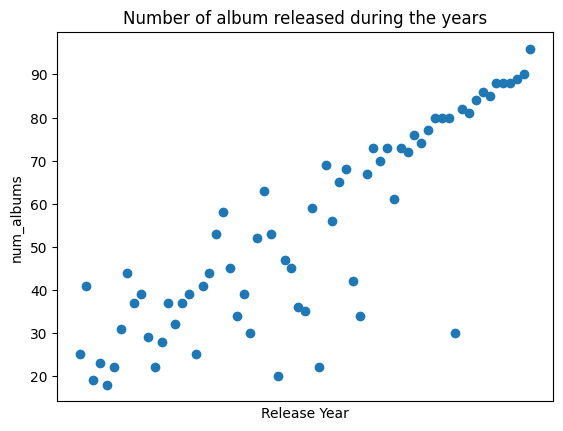

In [ ]:
import matplotlib.pyplot as plt
# Plot the data
plt.scatter(avg_popularity_by_years_df['release_year'], avg_popularity_by_years_df['num_albums'])
plt.title(f'Number of album released during the years')
plt.xlabel('Release Year')
plt.xticks([])
plt.ylabel('num_albums')
plt.show()

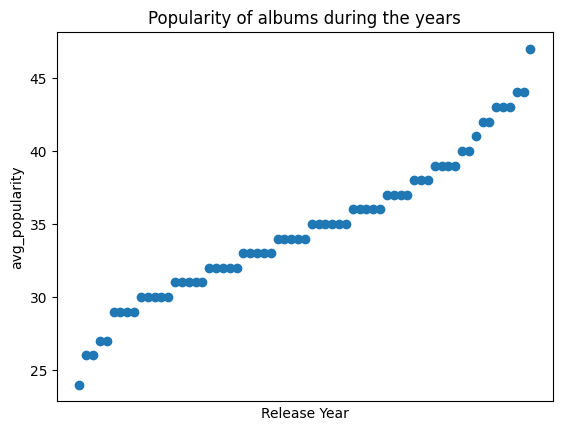

In [ ]:
import matplotlib.pyplot as plt
# Plot the data
plt.scatter(avg_popularity_by_years_df['release_year'], avg_popularity_by_years_df['avg_popularity'])
plt.title(f'Popularity of albums during the years')
plt.xlabel('Release Year')
plt.xticks([])
plt.ylabel('avg_popularity')
plt.show()

In [ ]:
max_avg_popularity_row = avg_popularity_by_years_df.loc[avg_popularity_by_years_df['avg_popularity'].idxmax()]

print("release_year with the maximum average popularity:")
print(max_avg_popularity_row['release_year'])

release_year with the maximum average popularity:
2023


In [ ]:

result_set = session.execute("""
SELECT *
FROM release_year_album_popularity
WHERE release_year='2023';""")
rows = list(result_set)


most_popular_year_in_music_df = pd.DataFrame(rows)

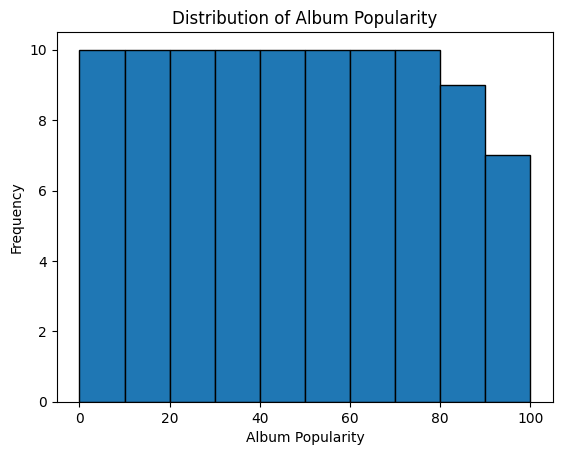

In [ ]:
# Assuming 'album_popularity' is a column in most_popular_year_in_music_df
album_popularity_values = most_popular_year_in_music_df['album_popularity'].astype(float)

# Plotting the distribution as a histogram
plt.hist(album_popularity_values, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Album Popularity')
plt.xlabel('Album Popularity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
most_popular_albums_2023 = most_popular_year_in_music_df[most_popular_year_in_music_df['album_popularity'] > 80]

In [ ]:
most_popular_albums_2023

,release_year,album_popularity,acousticness,album_id,album_name,album_type,artist_genres,artist_id,artists,danceability,...,release_day,release_month,speechiness,tempo,total_tracks,track_id,track_name,track_number,track_popularity,valence
81,2023,81,0.08470,35nmDyrcnDY4B1ISYpKEEs,For All The Dogs,album,"['canadian hip hop', 'canadian pop', 'hip hop'...",3TVXtAsR1Inumwj472S9r4,['Drake'],0.835,...,5,10,0.2700,185.983994,23,5FBX7QuxSorazVbaznYKfY,What Would Pluto Do,3,67,0.6120
82,2023,82,0.05690,5O0zUvdnJr0RbWzLFneN2i,Popular (Music From The Hbo Original Series),single,"['canadian contemporary r&b', 'canadian pop', ...",1Xyo4u8uXC1ZmMpatF05PJ,"['The Weeknd', 'Playboi Carti', 'Madonna']",0.855,...,2,6,0.1890,99.028999,1,6WzRpISELf3YglGAh7TXcG,Popular (With Playboi Carti & Madonna) - Music...,1,91,0.8520
83,2023,83,0.51000,4N1fROq2oeyLGAlQ1C1j18,Newjeans 2Nd Ep 'Get Up',single,"['k-pop', 'k-pop girl group']",6HvZYsbFfjnjFrWF950C9d,['NewJeans'],0.807,...,21,7,0.0508,134.014008,6,7woEDtme8YkFiWeyiinIjy,New Jeans,1,70,0.5320
84,2023,84,0.86700,3a6T0jJ6mF4KpBYvKH5o7Z,"Escolhas, Vol. 2 (Ao Vivo)",album,"['agronejo', 'arrocha', 'sertanejo', 'sertanej...",487N2T9nIPEHrlTZLL3SQs,['Zé Neto & Cristiano'],0.516,...,22,6,0.2110,75.734001,13,7F0OMeGRzoeJaHCMGRlOFE,Você Beberia Ou Não Beberia? - Ao Vivo,8,53,0.5210
85,2023,85,0.26100,7tzVd1fwkxsorytCBjEJkU,The Idol Episode 4 (Music From The Hbo Origina...,single,"['canadian contemporary r&b', 'canadian pop', ...",1Xyo4u8uXC1ZmMpatF05PJ,['The Weeknd'],0.298,...,23,6,0.0290,173.727997,3,5LffvExhQQFcfwqkGNpFpM,Jealous Guy,2,64,0.0576
86,2023,86,0.79800,5qmZefgh78fN3jsyPPlvuw,A Gift & A Curse,album,"['atl hip hop', 'melodic rap', 'rap', 'trap']",2hlmm7s2ICUX0LVIhVFlZQ,['Gunna'],0.827,...,16,6,0.4360,159.876999,15,6YD8EpsddOfEwAhaymGu0Q,I Was Just Thinking,15,65,0.8130
87,2023,87,0.33600,5DvJgsMLbaR1HmAI6VhfcQ,Endless Summer Vacation,album,['pop'],5YGY8feqx7naU7z4HrwZM6,['Miley Cyrus'],0.657,...,18,8,0.2390,183.925003,14,6eiNVtWCRsU7N6JDPXFI2W,Thousand Miles (Feat. Brandi Carlile),7,78,0.7720
88,2023,88,0.08130,2bYCNZfxZrTUv1CHXkz2d2,Pink Friday 2,album,"['hip pop', 'pop', 'queens hip hop', 'rap']",0hCNtLu0JehylgoiP8L4Gh,['Nicki Minaj'],0.928,...,8,12,0.3100,144.994995,22,2pwC49pIHyJKmbhlGa3lqL,Ftcu,3,77,0.9720
89,2023,90,0.90200,2Cn1d2KgbkAqbZCJ1RzdkA,The Land Is Inhospitable And So Are We,album,"['brooklyn indie', 'pov: indie']",2uYWxilOVlUdk4oV9DvwqK,['Mitski'],0.538,...,15,9,0.0423,129.975006,11,6YO2dalWyZSobXSY3UUPv9,When Memories Snow,8,98,0.3480
90,2023,91,0.16000,1o59UpKw81iHR0HPiSkJR0,1989 (Taylor'S Version) [Deluxe],album,['pop'],06HL4z0CvFAxyc27GXpf02,['Taylor Swift'],0.800,...,27,10,0.0397,116.998001,22,5QUIK7ZtziW8kGWo8RqopF,Welcome To New York (Taylor'S Version),5,82,0.6850


In [ ]:
# pip install wordcloud matplotlib


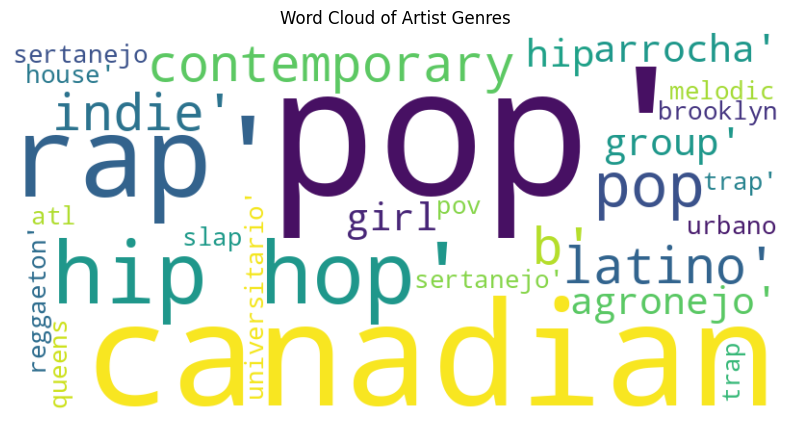

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_genres = ' '.join(most_popular_albums_2023['artist_genres'].astype(str))


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_genres)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most popular Genres in 2023')
plt.show()


In [ ]:
least_popular_albums_2023 = most_popular_year_in_music_df[most_popular_year_in_music_df['album_popularity'] < 25]

In [ ]:
least_popular_albums_2023

,release_year,album_popularity,acousticness,album_id,album_name,album_type,artist_genres,artist_id,artists,danceability,...,release_day,release_month,speechiness,tempo,total_tracks,track_id,track_name,track_number,track_popularity,valence
0,2023,0,0.93200,5N1e6evQBITBAmNSbK7XJV,Frequenze Di Guarigione: Un Viaggio Musicale A...,single,[],3ZwOn6LXemqwJ0Lfd8KQLF,['ShaunMadeIt'],0.6740,...,30,2,0.2370,140.951004,20,4UJVGApUx02hA4HXYUtxUo,Libertà Isochronica,3,3,0.6990
1,2023,1,0.71500,64tLUKC5TQHH1Cz38MOSyc,Rigor Mortis,single,[],3YINR1sEnX78cCjzyT8hHK,['Shawn Frost'],0.8290,...,5,12,0.4180,95.702003,1,5t4ehOqgP5Z5OnJoxNDz3x,Rigor Mortis,1,4,0.7290
2,2023,2,0.31900,2JytPV7ZVAjG8h4pp0kWfb,Out My Mind (Official Audio),single,[],3J4JZURFMB4vjeSa58rQED,['ShaunMadeIt'],0.6730,...,7,11,0.0688,129.979004,1,1caSWasd8gRs3TrnwqURuU,Out My Mind (Official Audio),1,6,0.6190
3,2023,3,0.27300,4ZOaRccEro9UrO6kazjCI8,Venus (Official Audio),single,[],3J4JZURFMB4vjeSa58rQED,"['ShaunMadeIt', 'Delic']",0.5460,...,5,10,0.1400,145.949997,1,2Cr92F78LzuR6XtXn2ECeN,Venus (Official Audio),1,7,0.3870
4,2023,4,0.12600,2VLch5dHPgqn84R5CTfBN9,Demi Cinta,single,[],3IyPPhFUvBbORNxeMbXiXx,"['Guslian', 'Rheina']",0.4650,...,28,1,0.0308,128.087006,1,1mfOywM6RZRPGWldli1h7J,Demi Cinta,1,9,0.2820
5,2023,5,0.25600,5m4Pa03jkP5berCYAok5Nn,Final Debut 2,single,[],3J4JZURFMB4vjeSa58rQED,['ShaunMadeIt'],0.6800,...,17,11,0.2720,142.070007,5,2ISEvUSvuRtGwUDeC2zHez,Racks On Racks,2,4,0.3550
6,2023,6,0.33500,4I8HYXwEMN1Ek2huoFuSHI,Nirvana Beyond Extreme,album,[],1griSTgADm38EsChU4lJ0L,['kodo17'],0.7220,...,13,11,0.0403,131.983994,8,1ExcYW7eaU9bn0HLEKpgpz,Vajrasattva,3,5,0.2800
7,2023,7,0.59600,6ux8c2fW5lA0qmpcoLQ4GP,A River,single,[],3Xr80iKgYbhiiA5XuJPeK5,['Seye Adelekan'],0.5370,...,28,7,0.0321,123.793999,1,4AbhDldPqrh7mZEK1TIF6f,A River,1,13,0.3380
8,2023,8,0.92200,59Z6kU92HqsriMPbb1jSlO,Vol.1,single,[],0O7G3syNJ9dv3QgvNLYniT,['Lo-Fighters'],0.7570,...,27,1,0.0572,159.973007,4,3EH16453OZsqejYn4MAQ7E,Gentle Rain,3,6,0.9650
9,2023,9,0.05040,6fFHUjKgqbrZnjoIPxfyIO,No Auto Shaun,single,[],3J4JZURFMB4vjeSa58rQED,['ShaunMadeIt'],0.6120,...,19,10,0.2660,164.992996,5,3tUcWCAH8FnBDsdhRK8otw,Out The Go,5,9,0.1040


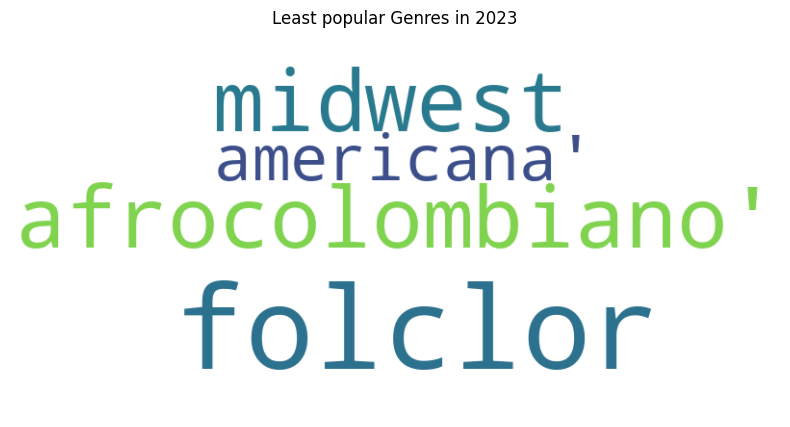

In [ ]:
all_genres = ' '.join(least_popular_albums_2023['artist_genres'].astype(str))


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_genres)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Least popular Genres in 2023')
plt.show()


In [ ]:

result_set = session.execute("SELECT release_year, AVG(album_popularity) AS avg_popularity, COLLECT(artist_genres) AS genres_list FROM albums_with_features GROUP BY release_year")
rows = list(result_set)


danceability_vs_popularity_df = pd.DataFrame(rows)

In [ ]:
cluster.shutdown()

## <u>non_batch solution for comparisson: <u>

In [ ]:
try:
    session.execute("""
        CREATE TABLE IF NOT EXISTS track_info_naive_2 (
            track_name TEXT,
            track_id TEXT,
            track_number TEXT,
            duration_ms TEXT,
            album_type TEXT,
            artists TEXT,
            total_tracks TEXT,
            album_name TEXT,
            release_date TEXT,
            label TEXT,
            album_popularity TEXT,
            album_id TEXT,
            artist_id TEXT,
            artist_0 TEXT,
            artist_1 TEXT,
            artist_2 TEXT,
            artist_3 TEXT,
            artist_4 TEXT,
            artist_5 TEXT,
            artist_6 TEXT,
            artist_7 TEXT,
            artist_8 TEXT,
            artist_9 TEXT,
            artist_10 TEXT,
            artist_11 TEXT,
            duration_sec TEXT,
            PRIMARY KEY (album_popularity, track_id));
    """)
except Exception as e:
    print(e)

## naive implementation for comparison
def df_to_cassandra_naive(path, prepared_query, types, batch_size=20, has_header=True):
        for index, row in path.iterrows():
            converted_vals = convert_to_types(types, row.tolist())
            session.execute(prepared_query, converted_vals)
            #print("yes")

types = [str]*26

statement = '''
INSERT INTO track_info_naive_2
(track_name,track_id,track_number,duration_ms,album_type,artists,total_tracks,album_name,release_date,label,album_popularity,album_id,artist_id,duration_sec,release_year,track_popularity,release_month,release_day,danceability,loudness,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
'''
prepared_query = session.prepare(statement)

# for max performance we should split out csv by partition
df_to_cassandra_naive(df, prepared_query, types)

